# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/guide/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/guide/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/guide/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/guide/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive/Judging under influence/datasets"

Mounted at /content/drive
FinalDatasetFullJudgements_NOFRENCH.csv  FinalDatasetParagraphs.csv


In [ ]:
!pip install git+https://github.com/tensorflow/docs   

import io
import random
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Bidirectional, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ivps6fit
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ivps6fit
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=13e86fc92437e79ee84193eac43fa385a0c67ebf821b2c3e5401fde3e5770090
  Stored in directory: /tmp/pip-ephem-wheel-cache-jt0y6ztg/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
Num GPUs Available:  1


## Setup

In [ ]:
#Keras do not implement F1 so I implemented "myself"
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#-----input and creating of tensors dataset
data = pd.read_csv("/content/drive/MyDrive/Judging under influence/datasets/FinalDatasetFullJudgements_NOFRENCH.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded
#data = pd.read_csv("FinalDatasetFullJudgements_NOFRENCH.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded

df=data.filter(["DEF","TEXT"], axis=1)
df=df.dropna() #non applicable deleted atm
df["DEF"]=df["DEF"].astype(int)
df.reset_index(drop=True, inplace=True) 


df.tail(20)

,DEF,TEXT
1684,0,1. This request for a preliminary ruling conce...
1685,0,1. These requests for a preliminary ruling con...
1686,0,1. This request for a preliminary ruling conce...
1687,0,1. This request for a preliminary ruling conce...
1688,1,1. This request for a preliminary ruling conce...
1689,0,1. This request for a preliminary ruling conce...
1690,0,1. This request for a preliminary ruling conce...
1691,0,1. This request for a preliminary ruling conce...
1692,0,1. This request for a preliminary ruling conce...
1693,1,1. This request for a preliminary ruling conce...


In [ ]:
df.iloc[1703].TEXT

'1. By its appeal, Kyocera Mita Europe BV (Â\x91Kyocera Mita EuropeÂ\x92) seeks to have set aside the order of the General Court of the European Union of 16Â\xa0September 2014 in Kyocera Mita Europe  v Commission  (T-35/11, EU:T:2014:795; Â\x91the order under appealÂ\x92), by which it declared inadmissible its action seeking the annulment in part of the annex to Commission Regulation (EU) NoÂ\xa0861/2010 of 5Â\xa0October 2010 amending Annex I to Council Regulation (EEC) NoÂ\xa02658/87 on the tariff and statistical nomenclature and on the Common Customs Tariff (OJ 2010 LÂ\xa0284, p.Â\xa01; Â\x91the contested regulationÂ\x92).\r\nLegal context\r\nRegulation (EEC) NoÂ\xa02913/922. The sixth and eighth recitals in the preamble to Council Regulation (EEC) NoÂ\xa02913/92 of 12Â\xa0October 1992 establishing the Community Customs Code (OJ 1992 LÂ\xa0302, p.Â\xa01), as amended by Council Regulation (EC) NoÂ\xa01186/2009 of 16Â\xa0November 2009 (OJ 2009 LÂ\xa0324, p.Â\xa023; Â\x91the Customs Cod

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer

def remove_punctuation_numbers(input_text):
    '''
    Function to remove English stopwords from a Pandas Series using NLTK.
    
    Parameters:
        input_text : text to clean as pandas series
    Output:
        cleaned Pandas Series 
    '''
    
    
    #select only the text, no puctuation
    tokenizer = RegexpTokenizer(r'\w+')
    #remove numbers
    text_nonum = re.sub(r'\d+', '', input_text)
    
    words = tokenizer.tokenize(text_nonum.lower())
    #words = input_text.lower().split() 
    #remove stopwords
    #clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(words) 

#remove the punctuation and numbers, keep stopwords
df['CLEAN_TEXT'] = df.TEXT.apply(remove_punctuation_numbers)
df

,DEF,TEXT,CLEAN_TEXT
0,0,1 . THE MEANING OF THE FIRST PARAGRAPH OF ARTI...,the meaning of the first paragraph of article ...
1,1,1 . THE QUESTION PUT BY THAT COURT REQUESTS TH...,the question put by that court requests the co...
2,0,1 . THE QUESTION ASKED BY THE SAID COURT FIRST...,the question asked by the said court first req...
3,0,1 . IT APPEARS FROM THE INFORMATION SUPPLIED B...,it appears from the information supplied by th...
4,0,1 . THE FIRST AND SECOND QUESTIONS\r\nIN ITS F...,the first and second questions in its first qu...
...,...,...,...
1699,1,1. This reference for a preliminary ruling con...,this reference for a preliminary ruling concer...
1700,0,1. This request for a preliminary ruling conce...,this request for a preliminary ruling concerns...
1701,1,1. This request for a preliminary ruling conce...,this request for a preliminary ruling concerns...
1702,0,"1. By its appeal, Canon Europa NV (ÂCanon Eur...",by its appeal canon europa nv â canon europaâ ...


In [ ]:
#we use clean text :)
target = df.pop('DEF')
dataset = tf.data.Dataset.from_tensor_slices((df.CLEAN_TEXT.values, target.values))

In [ ]:
#Here i get the split from the dataset, the split is 80 % for the k-fold and 20% for an independent test set.
#The test set is used to asses the performance on unseen data on the best cv values

#this is used for testing purposes, generates a dataset of nums from 0 to 19
#dataset = tf.data.Dataset.range(20)

DATASET_SIZE = dataset.cardinality().numpy()
SPLITS = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 #very important! Reducing this in RNN let them run on slower pc at the cost of exec time (increasing does the opposite)
TEST_SIZE = 0.15


def get_dataset_partitions(ds = dataset, ds_size= DATASET_SIZE, n_splits = SPLITS, test_size=TEST_SIZE, shuffle=True, shuffle_size=DATASET_SIZE, BATCH_SIZE = BATCH_SIZE):
    fold_size = 1/n_splits
    split_size = ds_size * (1-test_size) * fold_size
    CV_folds = []
    
    if shuffle:
        # Specify seed=xx to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=False, seed=5)#poi 1996
    
    test_dataset = ds.skip(ds_size * (1-test_size))
    cv_dataset = ds.take(ds_size * (1-test_size))
    
    #print(list(test_dataset.as_numpy_iterator()))
    #print(list(cv_dataset.as_numpy_iterator()))
    
    #print(list(test_dataset.as_numpy_iterator()))
    #print(list(cv_dataset.as_numpy_iterator()))
    
    for i in range(n_splits):         #dataset is divided in 3 pieces for each iteration, train1 | validation | train2 due to take/skip nature
        
        #we will concatenate train1 and train2 to define the fitting split for the current fold while val will be the validation
        
        train1 = cv_dataset.take(i * split_size) #each of the 2 train(1 and 2) can be of size [0,fold_size*num_splits-1], val have dimension= fold_size
        val = cv_dataset.skip(i * split_size).take(split_size)
        train2 = cv_dataset.skip(i * split_size).skip(split_size)
    
      
        #print(list(train1.concatenate(train2).as_numpy_iterator()))
        #print(list(val.as_numpy_iterator()))

        #we generate a list of tuples. Each tuple contain the train/validation for each fold. The list is indeed SPLITS-long.
        CV_folds.append([
                         train1.concatenate(train2).shuffle(train1.concatenate(train2).cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE),
                         val.shuffle(val.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
                        ])
        
        #print("CV:")
        #print(list(CV_folds[i][0].as_numpy_iterator()))
        ##print(list(CV_folds[i][1].as_numpy_iterator()))
        #print("--------------------------------------")
    
    
    return [CV_folds,
            test_dataset.shuffle(test_dataset.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE),
            cv_dataset.shuffle(cv_dataset.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)]
    


CV_folds, test_dataset, train_ds_final = get_dataset_partitions(shuffle=False)

#print(list(test_dataset.as_numpy_iterator()))
#print(list(train_ds_final.as_numpy_iterator()))

In [ ]:
#----- Class Imabalance dealing here
labels=[]
labels=np.array(labels)
for example, label in dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).take(-1):
    _ = example.numpy()
    labels=np.concatenate((labels,label.numpy()))
    
nonzero = np.count_nonzero(labels)
print("Total Number of 1 : "+str(nonzero))
print("Total Number of 0 : "+str(len(labels)-nonzero))

#positive/total ratio:
posWeight = len(labels)/nonzero
print("Weight of positive elements: "+str(posWeight))




Total Number of 1 : 305
Total Number of 0 : 1399
Weight of positive elements: 5.586885245901639


In [ ]:
#loading of tensorboard and deleting of old logs(windows10 only I guess)
%load_ext tensorboard
#shutil.rmtree("./logsGraphs", ignore_errors=True, onerror=None)

In [ ]:
#define the metrics I want to see during the iterations
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      f1, #my f1
      tf.keras.metrics.AUC(name='auc'),
    
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      
      
]

In [ ]:
def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(patience = 15, monitor = 'val_f1',  mode = 'max', min_delta = 0.01, restore_best_weights=True ),

    #tf.keras.callbacks.TensorBoard('logsGraphs/graphsFolder'),
  ]

In [ ]:
#here I defined the parameters i want to iterate through

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128, 256]))
HP_EMBEDDING_DIM = hp.HParam('emb_dim', hp.Discrete([64, 128, 256]))
HP_OPTIMIZER_LR = hp.HParam('opt_lr', hp.Discrete([0.001, 0.0005, 0.0001]))
HP_WEIGHT_TUNER = hp.HParam('pos_weight_tuner', hp.RealInterval(1.0,3.0))#selected later actually, but need a definition here
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([2, 3]))#always add +1 for the final layer
HP_NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([40]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
#HP_KERNEL_REGULARIZATION_L2 = hp.HParam('ker_l2', hp.Discrete([1e-25, 1e-4, 1e-5, 1e-6, 1e-7]))
#HP_KERNEL_REGULARIZATION_L1 = hp.HParam('ker_l1', hp.Discrete([1e-25, 1e-4, 1e-5, 1e-6, 1e-7]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.000000000000000000001, 0.1, 0.2, 0.25, 0.3]))
#here we choose the metrics we want to average after CV, we only choose the most important one to do not loose the focus
METRIC1 = 'f1'
METRIC2 = 'auc'#attention! If we have 0 precision/recall we might have errors due to AUC implmentation, MAY BE REMOVED

with tf.summary.create_file_writer('logsGraphs/hparam_tuningCV').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_EMBEDDING_DIM, HP_OPTIMIZER_LR, HP_WEIGHT_TUNER, HP_NUM_LAYERS, HP_NUM_EPOCHS, HP_OPTIMIZER,  HP_DROPOUT],
    metrics=[hp.Metric(METRIC1, display_name='f1'), hp.Metric(METRIC2, display_name='auc')],
  )



## Text preprocessing

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews. You can learn more about using this layer in the [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial.

## Create the CV classification model

In [ ]:
#this is the function that creates the ANN given the parameters.
#after creating it the ANN is fitted on the current split's train set and vchecked on the current validation set
#we return the f1 and auc of the current validation split as the measure of performance of this split
#the f1 and auc over all the splits will be later averaged and will be the parameters performance


# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 30000 #o 5k??

def train_test_model(emb_dim, num_units, learning_rate, weight_normalizer, num_layers, train_dataset, val_dataset, num_epochs, dropout, ker_l1=0, ker_l2=0, predictions = False, ret_model=False ):
  
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
  encoder.adapt(train_dataset.map(lambda text, label: text))

#---------------------------------------------------------------------
  model = Sequential([
      
  encoder,
    
  Embedding(#embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=emb_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
  Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.1,return_sequences=True)),
  
  Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.1)),    
  #Dropout(dropout)

  ])
    
  for i in range(num_layers):
    if num_units/pow(2,i) >1 :
        model.add(Dense(num_units/pow(2,i), activation="relu"))
        model.add(Dropout(dropout))
            
  model.add(Dense(1,activation='sigmoid')) 


  class_weight = {0: 1., #class 0 weight
                  1: posWeight/weight_normalizer, #uses the weight I set to make them perfectly balanced, I can increase it to overweight pos class!
                                     
                  2: 2.} 
    

  
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS,
  )
  
  history = model.fit(
             train_dataset,
             epochs=num_epochs,
             class_weight=class_weight,
             validation_data = val_dataset,
             callbacks=get_callbacks()
             ) 

  _, prec, recall, f1,auc, tp, tn, fp, fn, accuracy = model.evaluate(val_dataset)#validation we get our performances from this performance assesment
  
  if predictions:
    preds = model.predict(test_dataset,verbose =1)
    preds = [1 if num >= 0.5 else 0 for num in preds]
    return f1,auc,history,preds
  if ret_model:
    return f1,auc,history,model
  else:
    return f1,auc,history #we only take the most important measures to have a straightforward idea of performance

## RUN the created model

In [ ]:
#this method runs the cross validation, calling the above method giving it the parameters choosen and recording performances 
#it computes the average of f1 and auc over the various splits as well

def run(run_dir, hparams, session_num):
  with tf.summary.create_file_writer(run_dir).as_default():
    # record the values used in this trial
    hp.hparams(hparams)
    f1Score,auc = 0,0
    history = {}
    for i in range(SPLITS):#averaging over all the splits
      
      print("\nCHECKING SPLIT NUM: "+str(i+1))
      train_dataset,val_dataset = CV_folds[i]
      print()
      tmpf1,tmpauc,history["split "+str(i+1)],model = train_test_model(emb_dim = hparams[HP_EMBEDDING_DIM],
                                      num_units = hparams[HP_EMBEDDING_DIM], #!!! BEST PRACTICE
                                      learning_rate = hparams[HP_OPTIMIZER_LR],
                                      weight_normalizer= hparams[HP_WEIGHT_TUNER],
                                      num_layers = hparams[HP_NUM_LAYERS],
                                      num_epochs = hparams[HP_NUM_EPOCHS],
                                      #ker_l2 = hparams[HP_KERNEL_REGULARIZATION_L2],
                                      #ker_l1 = hparams[HP_KERNEL_REGULARIZATION_L1],
                                      dropout = hparams[HP_DROPOUT],
                                      train_dataset = train_dataset,
                                      val_dataset = val_dataset,
                                      ret_model = True)
        
      
      f1Score += tmpf1
      auc += tmpauc
      
    
    f1Score /= SPLITS
    auc /= SPLITS
    
    print("!!! SESSION NUM "+str(session_num)+" ---> CV VALIDATION f1: "+str(f1Score))
    print("!!! auc: "+str(auc))
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'f1', smoothing_std=10)
    plotter.plot(history)
    plt.show()
    print("\n------------------------------------------")
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
    plotter.plot(history)
    plt.show()
    
    
    tf.summary.scalar(METRIC1, f1Score, step = tf.convert_to_tensor(1, dtype=tf.int64))
    tf.summary.scalar(METRIC2, auc, step = tf.convert_to_tensor(1, dtype=tf.int64))
    
    return model

In [ ]:
## PARAMETERS TO TEST:
#these 2 are good results
#param = ['78', '280.186002', '0.001063', '2.229772', '2.080047', '0.174231']
#param = ['97.545495', '281.170117', '0.001063', '1.565771', '2.342309', '0.148752']
param =  ['30.422095', '26.887514', '0.000154', '1.090484', '0.513936', '0.147310']

Using parameters given by the operator
{'emb_dim': 30, 'num_units': 26, 'opt_lr': 0.000154, 'pos_weight_tuner': 1.090484, 'num_layers': 0, 'num_epochs': 50, 'dropout': 0.14731}

CHECKING SPLIT NUM: 1

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.1948 - precision: 0.1927 - recall: 0.7390 - f1: 0.2815 - auc: 0.5593 - tp: 201.0000 - tn: 334.0000 - fp: 842.0000 - fn: 71.0000 - accuracy: 0.3695
Epoch: 0, accuracy:0.3695,  auc:0.5593,  f1:0.2815,  fn:71.0000,  fp:842.0000,  loss:1.1948,  precision:0.1927,  recall:0.7390,  tn:334.0000,  tp:201.0000,  val_accuracy:0.1160,  val_auc:0.5254,  val_f1:0.2073,  val_fn:0.0000,  val_fp:320.0000,  val_loss:0.7023,  val_precision:0.1160,  val_recall:1.0000,  val_tn:0.0000,  val_tp:42.0000,  
34/34 [==============================] - 71s 2s/step - loss: 1.1948 - precision: 0.1927 - recall: 0.7390 - f1: 0.2815 - auc: 0.5593 - tp: 201.0000 - tn: 334.0000 - fp: 842.0000 - fn: 71.0000 - accuracy: 0.3695 - val_loss: 0.7023 - val_precis

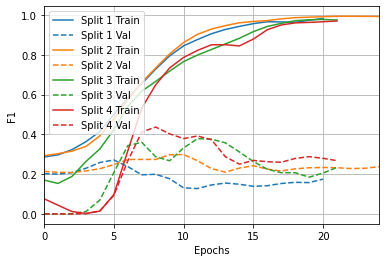


------------------------------------------


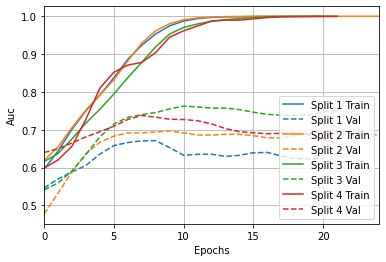

In [ ]:
#this is the highest-level method that runs the 2 above, call many times the run(....) method with different params combination

#you can choose: 1) to iterate one after all the paramters (not working atm, need to be added optimzier and num-epochs params)
#                2) Sample randomly from the paramters we have, useful for having a general idea of the performances

#the HParams framework is taken form the Tensorflow webpage as a "standard" hyperparameter optimization framework

def run_tuning(random_parameters):
    #take all the paramters one after all trying all the combinations
    if not random_parameters :
        
          #all values tuning way         
        print("Using parameters given by the operator")
        
        #print(param)
      
        hparams = {
          HP_EMBEDDING_DIM:int(float(param[0])),
          HP_NUM_UNITS: int(float(param[1])), #forse eb dim e num units sono inverititi
          HP_OPTIMIZER_LR: float(param[2]),
          HP_WEIGHT_TUNER:  float(param[3]),
          HP_NUM_LAYERS: int(float(param[4])),
          HP_NUM_EPOCHS: 50,
          #HP_KERNEL_REGULARIZATION_L2: ker_l2,
          #HP_KERNEL_REGULARIZATION_L1: ker_l1
          HP_DROPOUT: float(param[5])
        }


        print({h.name: hparams[h] for h in hparams})
        model = run('logsGraphs/hparam_tuningCV/' + "result check", hparams, 0)
        return model
                    
                
     #randomly sample parameters   
    if random_parameters :
        print("Trying parameters at random")
                 
        session_num = 0
        #this while is here simply because after around 20/25 combinations Colab RAM/my pc RAM is full and i need to restart
        while session_num <= 50:
            num_units = random.choice(HP_NUM_UNITS.domain.values)
            
            emb_dim = random.choice(HP_EMBEDDING_DIM.domain.values)
            opt_lr = random.choice(HP_OPTIMIZER_LR.domain.values)
            weight_tuner = random.choice([0.3,0.5,0.7,0.9, 1, 1.1, 1.2])
            num_layers = random.choice(HP_NUM_LAYERS.domain.values)
            num_epochs = random.choice(HP_NUM_EPOCHS.domain.values)
            optimizer = random.choice(HP_OPTIMIZER.domain.values)
            #ker_l2 = random.choice(HP_KERNEL_REGULARIZATION_L2.domain.values)
            #ker_l1 = random.choice(HP_KERNEL_REGULARIZATION_L1.domain.values)
            dropout = random.choice(HP_DROPOUT.domain.values)
            #creates a dictionary with the random sampled parameters, taken at random every time
            
            hparams = {
              HP_NUM_UNITS: emb_dim, #num un= emb_dim
              HP_EMBEDDING_DIM: emb_dim,
              HP_OPTIMIZER_LR: opt_lr,
              HP_WEIGHT_TUNER: weight_tuner,
              HP_NUM_LAYERS: num_layers,
              HP_NUM_EPOCHS: num_epochs,
              HP_OPTIMIZER: optimizer,
              #HP_KERNEL_REGULARIZATION_L2: ker_l2,
              #HP_KERNEL_REGULARIZATION_L1: ker_l1
              HP_DROPOUT: dropout
            }
            
            run_name = "run-%d" % session_num
            
            print("!--WARNING--! DROPOUT and CLASS_WEIGHT are DISABLED and  EMB_DIM=NUM_UNITS")
            
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            
            #call the run(..) method defined earlier
            run('logsGraphs/hparam_tuningCV/' + run_name, hparams, session_num)
            
            
            
            session_num += 1

                
model = run_tuning(random_parameters=False)

## Test check

In [ ]:
def runTest(run_dir, hparams, session_num, predictions=False,ret_model=False):
  with tf.summary.create_file_writer(run_dir).as_default():
    # record the values used in this trial
    hp.hparams(hparams)
    f1Score,auc = 0,0 
    history = {}
    
      
    
      
    
    f1Score,auc,history["split "+str(0)],model = train_test_model(emb_dim = hparams[HP_EMBEDDING_DIM],
                                  num_units = hparams[HP_EMBEDDING_DIM], #!!! BEST PRACTICE
                                  learning_rate = hparams[HP_OPTIMIZER_LR],
                                  weight_normalizer= hparams[HP_WEIGHT_TUNER],
                                  num_layers = hparams[HP_NUM_LAYERS],
                                  num_epochs = hparams[HP_NUM_EPOCHS],
                                  #ker_l2 = hparams[HP_KERNEL_REGULARIZATION_L2],
                                  #ker_l1 = hparams[HP_KERNEL_REGULARIZATION_L1],
                                  dropout = hparams[HP_DROPOUT],
                                  train_dataset = train_ds_final,
                                  val_dataset = test_dataset,
                                  ret_model = True)
 
    print("!!! f1: "+str(f1Score))
    print("!!! auc: "+str(auc))
    
    #vocab 15k
    plotter = tfdocs.plots.HistoryPlotter(metric = 'f1', smoothing_std=10)
    plotter.plot(history)
    plt.show() 

    plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
    plotter.plot(history)
    plt.show() 

    plotter = tfdocs.plots.HistoryPlotter(metric = 'tp', smoothing_std=10)
    plotter.plot(history)
    plt.show() 

    plotter = tfdocs.plots.HistoryPlotter(metric = 'tn', smoothing_std=10)
    plotter.plot(history)
    plt.show() 

    plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
    plotter.plot(history)
    plt.show() 
    
    
    tf.summary.scalar(METRIC1, f1Score, step = tf.convert_to_tensor(1, dtype=tf.int64))
    tf.summary.scalar(METRIC2, auc, step = tf.convert_to_tensor(1, dtype=tf.int64))
    
    if predictions:
      return preds

    if ret_model:
      return model

Using parameters given by the operator
{'num_units': 26, 'emb_dim': 30, 'opt_lr': 0.000154, 'pos_weight_tuner': 0.513936, 'num_layers': 1, 'num_epochs': 50, 'dropout': 0.14731}
Epoch 1/50


2022-04-14 13:28:00.742825: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


46/46 [==============================] - ETA: 0s - loss: 1.7793 - precision: 0.1650 - recall: 0.9270 - f1: 0.2673 - auc: 0.5266 - tp: 216.0000 - tn: 122.0000 - fp: 1093.0000 - fn: 17.0000 - accuracy: 0.2334
Epoch: 0, accuracy:0.2334,  auc:0.5266,  f1:0.2673,  fn:17.0000,  fp:1093.0000,  loss:1.7793,  precision:0.1650,  recall:0.9270,  tn:122.0000,  tp:216.0000,  val_accuracy:0.2812,  val_auc:0.5000,  val_f1:0.4345,  val_fn:0.0000,  val_fp:184.0000,  val_loss:0.7123,  val_precision:0.2812,  val_recall:1.0000,  val_tn:0.0000,  val_tp:72.0000,  
46/46 [==============================] - 84s 2s/step - loss: 1.7793 - precision: 0.1650 - recall: 0.9270 - f1: 0.2673 - auc: 0.5266 - tp: 216.0000 - tn: 122.0000 - fp: 1093.0000 - fn: 17.0000 - accuracy: 0.2334 - val_loss: 0.7123 - val_precision: 0.2812 - val_recall: 1.0000 - val_f1: 0.4345 - val_auc: 0.5000 - val_tp: 72.0000 - val_tn: 0.0000e+00 - val_fp: 184.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.2812
Epoch 2/50
46/46 [=====================

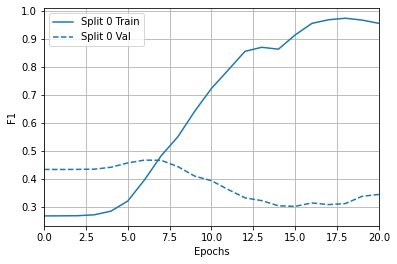

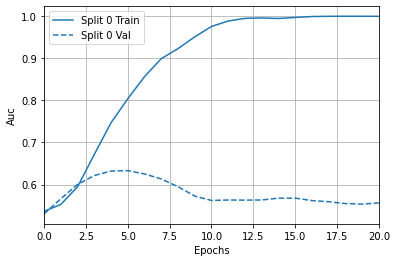

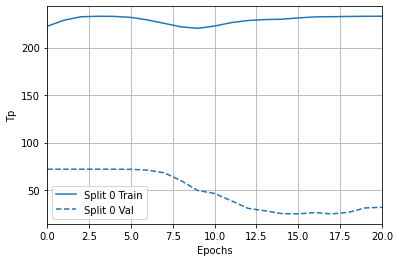

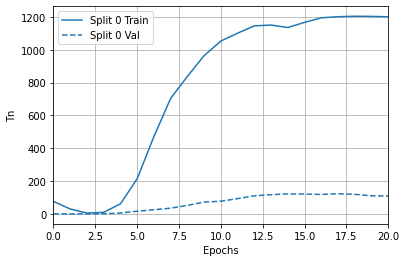

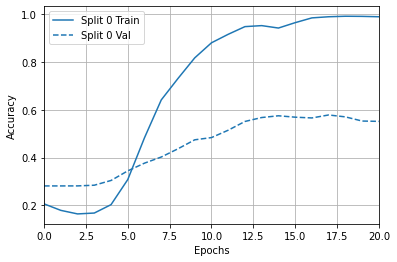

In [ ]:
print("Using parameters given by the operator")


hparams = {
          HP_NUM_UNITS: int(float(param[1])), #num un= emb_dim
          HP_EMBEDDING_DIM:int(float(param[0])),
          HP_OPTIMIZER_LR: float(param[2]),
          HP_WEIGHT_TUNER:  float(param[4]),
          HP_NUM_LAYERS: int(float(param[3])),
          HP_NUM_EPOCHS: 50,
          #HP_KERNEL_REGULARIZATION_L2: ker_l2,
          #HP_KERNEL_REGULARIZATION_L1: ker_l1
          HP_DROPOUT: float(param[5])
        }


print({h.name: hparams[h] for h in hparams})
final_model = runTest('logsGraphs/hparam_tuningCV/' + "result check", hparams, 0, ret_model = True)

## Save model for further usage

In [ ]:
final_model.save('DEF_RNN_FULL',save_format='tf')

2022-04-14 13:51:46.574573: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: DEF_RNN_FULL/assets


INFO:tensorflow:Assets written to: DEF_RNN_FULL/assets


In [ ]:
#loaded_model.load_weights()
#we set compile=False because of the custom losses that can't be loaded 
new_model = tf.keras.models.load_model('DEF_RNN_FULL',compile=False)
new_model.summary()

2022-04-14 13:52:11.729068: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-14 13:52:12.245834: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-14 13:52:13.063274: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-04-14 13:52:13.630502: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-04-14 13:52:13.643638: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _ou

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 30)          731730    
                                                                 
 bidirectional (Bidirectiona  (None, None, 60)         14640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               21840     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                        

In [ ]:
learning_rate = param[2]
new_model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS,
      )



In [ ]:
#get you result on the independent test set to asses performance on unseen data
test_loss,  test_prec, test_rec, test_f1, test_auc,_1,_2,_3,_4,test_acc = new_model.evaluate(test_dataset)


print('Test Accuracy:', test_acc)
print('Test Prec:', test_prec)
print('Test Recall:', test_rec)
print('Test AUC:', test_auc)
print('Test F1: ',test_f1)
print('Test Loss:', test_loss)

8/8 [==============================] - 13s 643ms/step - loss: 1.3192 - precision: 0.3064 - recall: 1.0000 - f1: 0.4633 - auc: 0.6388 - tp: 144.0000 - tn: 42.0000 - fp: 326.0000 - fn: 0.0000e+00 - accuracy: 0.3633
Test Accuracy: 0.36328125
Test Prec: 0.3063829839229584
Test Recall: 1.0
Test AUC: 0.6388133764266968
Test F1:  0.4633178412914276
Test Loss: 1.3192369937896729


## Dummy predictor

In [ ]:
from sklearn.metrics import recall_score,precision_score,roc_curve,roc_auc_score,f1_score,accuracy_score

test_labels=[]
test_labels=np.array(test_labels)
for example, label in test_dataset.take(-1):
    _ = example.numpy()
    test_labels=np.concatenate((test_labels,label.numpy()))
    
#print(test_labels)

#Results using dummy classification on the test set
accuracy = accuracy_score(test_labels,np.zeros(len(test_labels)))#predict all zeroes
precision = precision_score(test_labels,np.zeros(len(test_labels)))
recall = recall_score(test_labels,np.zeros(len(test_labels)))
auc = roc_auc_score(test_labels,np.zeros(len(test_labels)))
f1 = f1_score(test_labels,np.zeros(len(test_labels)))



print("Precision : "+str(precision))
print("Recall : "+str(recall))
print("AUC : "+str(auc))
print("F1 : "+str(f1))
print("accuracy: "+str(accuracy))

Precision : 0.0
Recall : 0.0
AUC : 0.5
F1 : 0.0
accuracy: 0.71875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Get predictions of the whole dataset

In [ ]:
#-----input and creating of tensors dataset
data = pd.read_csv("/content/drive/MyDrive/Judging under influence/DEF_VM/FinalDatasetFullJudgements_NOFRENCH.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded

df=data.filter(["DEF","TEXT","celex"], axis=1)
#print(df.head())
df=df.dropna() #non applicable deleted atm
df["DEF"]=df["DEF"].astype(int)
#df.reset_index(drop=True, inplace=True) 
target = df.pop('DEF')
#!ATTENTION now in df.values i have both text and celex
dataset = tf.data.Dataset.from_tensor_slices((df.TEXT.values, target.values))
df

,TEXT
celex,
61960CJ0009,1 . THE MEANING OF THE FIRST PARAGRAPH OF ARTI...
61963CJ0075,1 . THE QUESTION PUT BY THAT COURT REQUESTS TH...
61963CJ0092,1 . THE QUESTION ASKED BY THE SAID COURT FIRST...
61964CJ0024,1 . IT APPEARS FROM THE INFORMATION SUPPLIED B...
61965CJ0057,1 . THE FIRST AND SECOND QUESTIONS\r\nIN ITS F...
...,...
62014CJ0378,1. This reference for a preliminary ruling con...
62014CJ0402,1. This request for a preliminary ruling conce...
62014CJ0427,1. This request for a preliminary ruling conce...


In [ ]:
final_full_dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)#no shuffle bc shufffled sempre prima wuindi p come fosse shuffled anche ora

In [ ]:
preds = final_model.predict(final_full_dataset,verbose=1)

27/27 [==============================] - 51s 2s/step


In [ ]:
#t_arr = []
#labels = []
#celexs = []

#for example, label, celex in final_full_dataset.take(-1):
##for example, label in train_dataset.take(-1):
#    #print(example.numpy())
#    t_arr = np.concatenate((t_arr,example.numpy().flatten()))  
#    labels = np.concatenate((labels,label.numpy()))
#    celexs = np.concatenate((celexs,celex.numpy()))

In [ ]:
#res=model.predict(test_dataset,verbose =1)
res = [1 if num >= 0.5 else 0 for num in preds]
#[str(m)+'|'+str(n) for m,n in zip(res,target.values.astype(int))]


In [ ]:
df.TEXT[0]

"1 . THE MEANING OF THE FIRST PARAGRAPH OF ARTICLE 40\r\nTHE FIRST PARAGRAPH OF ARTICLE 40 DEALS WITH DISPUTES CONCERNING THE LIABILITY OF THE COMMUNITY FOR WRONGFUL ACTS OR OMISSIONS .\r\nTHE ACTION FOR REPARATION REFERRED TO IN ARTICLE 40 DIFFERS FROM AN APPLICATION FOR ANNULMENT BOTH IN ITS SUBJECT-MATTER AND IN THE NATURE OF THE GROUNDS WHICH MAY BE PLEADED . AS REGARDS ITS SUBJECT-MATTER, AN ACTION FOR REPARATION IS DIRECTED NOT TO THE ABOLITION OF A PARTICULAR MEASURE BUT ONLY TO REPARATION OF DAMAGE CAUSED BY AN ACT OR FAILURE TO ACT AMOUNTING TO A WRONGFUL ACT OR OMISSION . AS REGARDS THE GROUNDS ON WHICH AN ACTION FOR REPARATION MAY BE BASED ONLY THE EXISTENCE OF A WRONGFUL ACT OR OMISSION CAN LEAD TO A FINDING AGAINST THE HIGH AUTHORITY WHEREAS AN APPLICATION FOR ANNULMENT ENABLES THE FOUR GROUNDS MENTIONED IN ARTICLE 33 TO BE PLEADED .\r\nARTICLE 40 CONSEQUENTLY CONFERS ON THE COURT A JURISDICTION WHICH IS CLEARLY DIFFERENT FROM THAT WHICH IT EXERCISES IN DISPUTES CONCERNING

In [ ]:
import pandas as pd

data = zip(df.index.values,df.TEXT.values,target.values.astype(int), res)
final_df = pd.DataFrame(data, columns=('celex','TEXT', 'DEF', 'PRED_DEF'))
#df['TEXT']=df['TEXT'].str.decode("utf-8")
print(final_df)


            celex                                               TEXT  DEF  \
0     61960CJ0009  1 . THE MEANING OF THE FIRST PARAGRAPH OF ARTI...    0   
1     61963CJ0075  1 . THE QUESTION PUT BY THAT COURT REQUESTS TH...    1   
2     61963CJ0092  1 . THE QUESTION ASKED BY THE SAID COURT FIRST...    0   
3     61964CJ0024  1 . IT APPEARS FROM THE INFORMATION SUPPLIED B...    0   
4     61965CJ0057  1 . THE FIRST AND SECOND QUESTIONS\r\nIN ITS F...    0   
...           ...                                                ...  ...   
1699  62014CJ0378  1. This reference for a preliminary ruling con...    1   
1700  62014CJ0402  1. This request for a preliminary ruling conce...    0   
1701  62014CJ0427  1. This request for a preliminary ruling conce...    1   
1702  62014CJ0552  1. By its appeal, Canon Europa NV (ÂCanon Eur...    0   
1703  62014CJ0553  1. By its appeal, Kyocera Mita Europe BV (ÂKy...    0   

      PRED_DEF  
0            0  
1            1  
2            1  
3      

In [ ]:
final_df.to_csv("predictions_DEF_full_judgements.csv")

In [ ]:
#group by celex and do maj voting on the label for the paragraph
final_agg = final_df.groupby(['celex'])['PRED_DOCOUT'].agg(
    lambda x: pd.Series.mode(x)[0])

In [ ]:
final_agg.head()

In [ ]:
final_agg.loc['61963CJ0075']

In [ ]:
#reset index to merge
final_agg = final_agg.reset_index( )

#read other df fro full labels values
data = pd.read_csv("FinalDatasetFullJudgements_NOFRENCH.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded
df2=data.filter(["DOCOUT","TEXT","celex"], axis=1)

final_agg.head()

In [ ]:
merged_df = df2.merge(final_agg, how = 'inner', on = ['celex'])
merged_df.DOCOUT = merged_df.DOCOUT.astype('int')
merged_df

In [ ]:
merged_df.to_csv("DOCOUT_aggregated_judgements.csv")

In [ ]:
#compute performances on majority voting
from sklearn.metrics import accuracy_score,f1_score

print("Performance of the majority voting of aggregated paragraphs")
print("Accuracy: "+str(accuracy_score(y_true = merged_df.DOCOUT,y_pred = merged_df.PRED_DOCOUT)))
print("F1 score : "+str(f1_score(y_true = merged_df.DOCOUT,y_pred = merged_df.PRED_DOCOUT)))

In [ ]:
print("Performance of the single classification of paragraphs")
print("Accuracy: "+str(accuracy_score(y_true = final_df.DOCOUT,y_pred = final_df.PRED_DOCOUT)))
print("F1 score : "+str(f1_score(y_true = final_df.DOCOUT,y_pred = final_df.PRED_DOCOUT)))